In [1]:
import os
import scipy.io
import numpy as np

raw_data = {'normal': [], 'af': [], 'other': [], 'noisy': []}
raw_val_data = {'normal': [], 'af': [], 'other': [], 'noisy': []}

training_dir = os.path.join('..', 'data', 'training')
validation_dir = os.path.join('..', 'data', 'validation')

for Dir in [training_dir, validation_dir]:
    for Class in ['normal', 'af', 'other', 'noisy']:
        class_dir = os.path.join(Dir, Class)
        for file in [os.path.join(class_dir, _) for _ in os.listdir(class_dir) if _.endswith('.mat')]:
            mat_data = scipy.io.loadmat(file)
            sequence = mat_data['val'][0]
            
            if Dir == training_dir:
                raw_data[Class].append(sequence)
            else:
                raw_val_data[Class].append(sequence)

In [3]:
print(len(raw_data['af']))

738


In [59]:
from ecgdetectors import Detectors
fs = 300

detectors = Detectors(fs)

rrs_normal = []
drrs_normal = []

for x in raw_data['normal']:
    peaks = detectors.swt_detector(x)
    rr = []
    for p in range(len(peaks)-1):
        rr.append((peaks[p+1]-peaks[p])/fs)
    
    drr = []
    for r in range(len(rr)-1):
        drr.append(rr[r+1]-rr[r])
    rrs_normal.append(rr[1:])
    drrs_normal.append(drr)

rrs_af = []
drrs_af = []

for x in raw_data['af']:
    peaks = detectors.hamilton_detector(x)
    rr = []
    for p in range(len(peaks)-1):
        rr.append((peaks[p+1]-peaks[p])/fs)
    
    drr = []
    for r in range(len(rr)-1):
        drr.append(rr[r+1]-rr[r])
    rrs_af.append(rr[1:])
    drrs_af.append(drr)

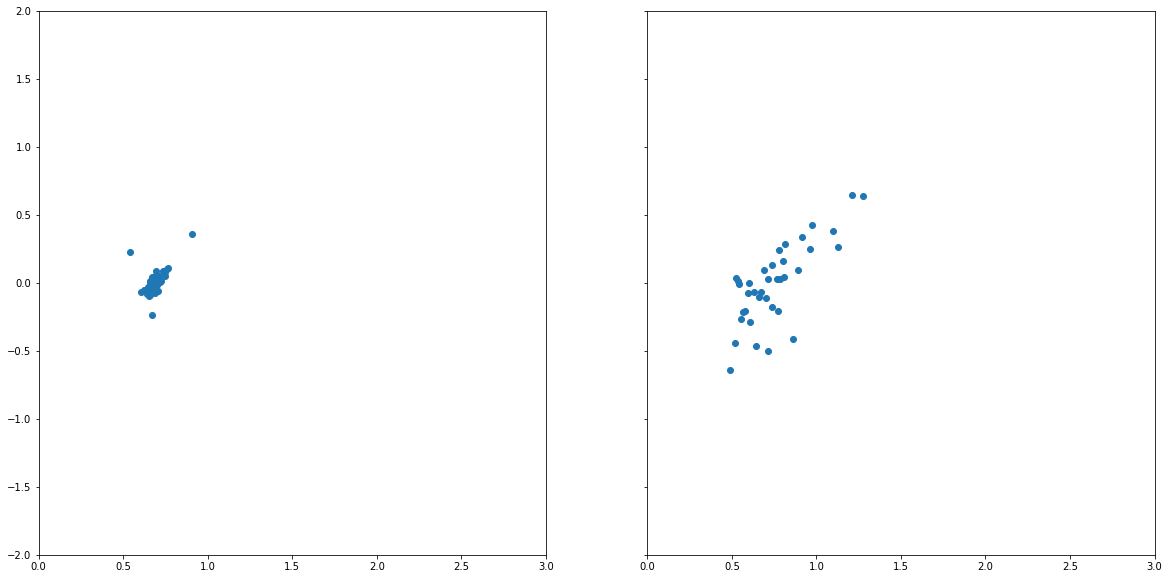

In [70]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(20, 10)
plt.xlim([0, 3])
plt.ylim([-2, 2])

axs[0].scatter(rrs_normal[4], drrs_normal[4])
axs[1].scatter(rrs_af[0], drrs_af[0])

In [61]:
# m = len(max(rrs_af, key=len))
# rrs_af_padded = []
# for i in rrs_af:
#     curr = np.pad(i, (0, m-len(i)))
#     rrs_af_padded.append(curr)
    
# m = len(max(drrs_af, key=len))
# drrs_af_padded = []
# for i in drrs_af:
#     curr = np.pad(i, (0, m-len(i)))
#     drrs_af_padded.append(curr)

# m = len(max(rrs_normal, key=len))
# rrs_normal_padded = []
# for i in rrs_normal:
#     curr = np.pad(i, (0, m-len(i)))
#     rrs_normal_padded.append(curr)

# m = len(max(drrs_normal, key=len))
# drrs_normal_padded = []
# for i in drrs_normal:
#     curr = np.pad(i, (0, m-len(i)))
#     drrs_normal_padded.append(curr)

In [87]:
initial_grid = {}

for i in np.arange(0, 3, 0.025):
    for j in np.arange(-2, 2, 0.025):
        initial_grid[(i, j)] = False

0

In [90]:
def round_to_25(x):
    return x - x % 0.025

In [105]:
x_normal = []
for i in range(len(rrs_normal)):
    for w in range(0, len(rrs_normal)-32, 32):
        if w+32 < len(rrs_normal[i]):
            curr_grid = dict(initial_grid)
            for j in range(32):
                curr_grid[round_to_25(rrs_normal[i][w+j]), round_to_25(drrs_normal[i][w+j])] = True
            x_normal.append(sum(curr_grid.values()))

x_af = []
for i in range(len(rrs_af)):
    for w in range(0, len(rrs_af)-32, 32):
        if w+32 < len(rrs_af[i]):
            curr_grid = dict(initial_grid)
            for j in range(32):
                curr_grid[round_to_25(rrs_af[i][w+j]), round_to_25(drrs_af[i][w+j])] = True
            x_af.append(sum(curr_grid.values()))

In [106]:
print(np.mean(x_normal), np.mean(x_af))

23.85869885192817 27.62330623306233


In [112]:
y_normal = [0]*len(x_af)
y_af = [1]*len(x_af)

x = np.concatenate((x_normal[:len(x_af)], x_af))
y = np.concatenate((y_normal, y_af))

p = np.random.permutation(len(x))
x = x[p]
y = y[p]

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

x = np.reshape(x, (-1, 1))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = SVC(C=25, gamma=1, probability=True)
model.fit(x_train, y_train)
print(model.score(x_test, y_test))


0.7364864864864865
